# *Problem Set 7*

# Problems 1 to 4

## Environment Setup

In [ ]:
# library imports
import numpy as np
import pandas as pd
from IPython.display import display
import math
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading and Preprocessing the Data

In [ ]:
# loading the data with pandas
data_path = "/content/drive/MyDrive/preprogram/stats/ps7_data.txt"
df = pd.read_csv(data_path)
df.shape
df.head()

(264, 6)

,Date,PG,UN,HH,MKT,RF
0,1994-01-31,0.008772,0.004329,0.0247,0.0312,0.0025
1,1994-02-28,0.016397,0.020473,-0.0121,-0.0235,0.0021
2,1994-03-31,-0.019355,-0.061245,-0.0504,-0.0451,0.0027
3,1994-04-30,-0.078947,-0.087739,0.0164,0.0095,0.0027
4,1994-05-31,0.082419,0.092478,0.0092,0.0089,0.0031


In [ ]:
# checking for nulls
for col in df.columns:
  df[col].isna().sum()

0

0

0

0

0

0

In [ ]:
# subtracting risk free rate from returns
for col in ["PG", "UN", "HH", "MKT"]:
  new_col = "{}_excess".format(col.lower())
  df[new_col] = (df[col] - df["RF"])
df.head()

,Date,PG,UN,HH,MKT,RF,pg_excess,un_excess,hh_excess,mkt_excess
0,1994-01-31,0.008772,0.004329,0.0247,0.0312,0.0025,0.006272,0.001829,0.0222,0.0287
1,1994-02-28,0.016397,0.020473,-0.0121,-0.0235,0.0021,0.014297,0.018373,-0.0142,-0.0256
2,1994-03-31,-0.019355,-0.061245,-0.0504,-0.0451,0.0027,-0.022055,-0.063945,-0.0531,-0.0478
3,1994-04-30,-0.078947,-0.087739,0.0164,0.0095,0.0027,-0.081647,-0.090439,0.0137,0.0068
4,1994-05-31,0.082419,0.092478,0.0092,0.0089,0.0031,0.079319,0.089378,0.0061,0.0058


In [ ]:
# adding a constant 1 column
# will be useful to incorporate intercept into beta
df["const"] = 1
df.head()

,Date,PG,UN,HH,MKT,RF,pg_excess,un_excess,hh_excess,mkt_excess,const
0,1994-01-31,0.008772,0.004329,0.0247,0.0312,0.0025,0.006272,0.001829,0.0222,0.0287,1
1,1994-02-28,0.016397,0.020473,-0.0121,-0.0235,0.0021,0.014297,0.018373,-0.0142,-0.0256,1
2,1994-03-31,-0.019355,-0.061245,-0.0504,-0.0451,0.0027,-0.022055,-0.063945,-0.0531,-0.0478,1
3,1994-04-30,-0.078947,-0.087739,0.0164,0.0095,0.0027,-0.081647,-0.090439,0.0137,0.0068,1
4,1994-05-31,0.082419,0.092478,0.0092,0.0089,0.0031,0.079319,0.089378,0.0061,0.0058,1


In [ ]:
# data for question 1
X1 = df[["const", "mkt_excess"]].to_numpy()
X1.shape
y1 = df["un_excess"].to_numpy()
y1.shape

# data for question 2
X2 = df[["const", "mkt_excess", "hh_excess"]].to_numpy()
X2.shape
y2 = df["un_excess"].to_numpy()
y2.shape

(264, 2)

(264,)

(264, 3)

(264,)

# Utilities for Problems 1 and 2

In [ ]:
# part a
# fitting the regression to calculate beta
def fit_ols(X, y):
  inv_XTX = np.linalg.inv(np.matmul(
      np.transpose(X), X
  ))
  XTy = np.matmul(np.transpose(X), y)
  beta = np.matmul(inv_XTX, XTy)
  return beta

# calculate R2 and adjusted R2
def calculate_r2(X, y, beta):
  sst = np.sum((y - np.mean(y)) ** 2)
  y_hat = np.matmul(X, beta)
  ssr = np.sum((y_hat - np.mean(y)) ** 2)
  r2 = ssr / sst

  n, k = X.shape[0], X.shape[1]
  adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
  return r2, adj_r2

# part b
# plot scatter plot of UL versus MKT (CRSP-VW)
# and the regression line
def plot_regression_line(X, y, beta):
  if X.shape[1] > 2:
    new_X = X[:, :2]
    X = np.concatenate([
        new_X, np.ones((new_X.shape[0], 1)) * np.mean(X[:, 2])
    ], axis = 1)
  y_hat = np.matmul(X, beta)
  # CRSP-VW is 1st column in X
  plt.scatter(X[:, 1], y, color = "red", label = "actual UL returns")
  x = X[:, 1]
  order = x.argsort()
  y_hat, x = y_hat[order], x[order]
  plt.plot(x, y_hat, color = "blue", label = "regression_line")
  plt.ylabel("UL Returns - RF", fontsize = 15)
  plt.xlabel("CRSP-VW Returns - RF", fontsize = 15)
  plt.legend()
  plt.title("UL Returns vs CRSP-VW Returns", fontsize = 20)
  plt.show()

# part c
# calculating the covariance matrix under assumption of homoskedasticity
def homoskedastic_covariance_matrix(X, y, beta):
  y_hat = np.matmul(X, beta)
  sse = np.sum((y - y_hat) ** 2)
  error_variance = sse / X.shape[0]
  inv_XTX = np.linalg.inv(np.matmul(
      np.transpose(X), X
  ))
  cov_matrix = error_variance * inv_XTX
  return cov_matrix

# part d and i
# null hypothesis: beta = b0
def test_regression_coefficients(X, beta, V, b0 = 0):
  sb = V.diagonal() ** 0.5
  t = (beta - b0) / sb
  n, k = X.shape[0], X.shape[1]
  p_value = 2 * (1 - stats.t.cdf(abs(t), n - k))
  return p_value

# part e
# plot squared residuals
def assess_homoskedasticity(X, y, beta):
  y_hat = np.matmul(X, beta)
  e_sq = (y - y_hat) ** 2
  plt.plot(e_sq)
  plt.title("Squared Residuals", fontsize = 20)
  plt.show()

# part f and h
# getting the standard errors and
# 0.9, 0.95, and 0.99 confidence intervals for coefficients
def get_ci_estimates(X, beta, V):
  ci_intervals = np.array([0.9, 0.95, 0.99])
  dof = X.shape[0] - X.shape[1]
  t_values = -stats.t.ppf((1 - ci_intervals) / 2, dof)
  sb = V.diagonal() ** 0.5
  result = dict()
  result["standard_errors"] = sb
  for i in range(len(ci_intervals)):
    t_value = t_values[i]
    lower_bounds = beta - sb * t_value
    upper_bounds = beta + sb * t_value
    result[ci_intervals[i]] = [(l, u) for l, u in zip(
        lower_bounds, upper_bounds
    )]
  return result

# part g
# calculating covariance matrix under assumption of heteroskedasticity
def heteroskedastic_covariance_matrix(X, y, beta):
  y_hat = np.matmul(X, beta)
  sse = np.sum((y - y_hat) ** 2)
  error_variance = sse / X.shape[0]
  D = error_variance * np.identity(y.shape[0])
  XTDX = np.matmul(np.transpose(X), np.matmul(D, X))
  inv_XTX = np.linalg.inv(np.matmul(
      np.transpose(X), X
  ))
  V = np.matmul(np.matmul(inv_XTX, XTDX), inv_XTX)
  return V

# part j
# calculation of AIC, BIC, and Hannah-Quinn IC
def calculate_information_criteria(X, y, beta):
  y_hat = np.matmul(X, beta)
  sse = np.sum((y - y_hat) ** 2)
  error_variance = sse / X.shape[0]
  logl = np.sum(np.log(
      1 / (2 * math.pi * error_variance) * np.exp(
          -1 / (2 * error_variance) * (y - y_hat) ** 2
      )
  ))
  n, k = X.shape[0], X.shape[1]
  aic = -2 * logl + 2 * k
  bic = -2 * logl + k * np.log(n)
  hqc = -2 * logl + 2 * k * np.log(np.log(n))
  return aic, bic, hqc

# part k
# durbin-watson and breusch-godfrey tests
def residual_autocorrelation_tests(X, y, beta, significance = 0.95):
  y_hat = np.matmul(X, beta)
  e = y - y_hat

  # durbin-watson test
  result = dict()
  result["dw"] = np.sum((e[1:] - e[:-1]) ** 2) / np.sum(e[1:] ** 2)

  # breusch-godfrey test with 1st order autocorrelation
  e_y, e_X = e[1:], e[:-1]
  e_X = np.concatenate([
      np.ones((e_X.shape[0], 1)), np.reshape(e_X, (e_X.shape[0], 1))
  ], axis = 1)
  beta = fit_ols(e_X, e_y)
  r2, _ = calculate_r2(e_X, e_y, beta)
  result["bg"] = (e[1:].shape[0] - 1) * r2

  # 1-alpha critical values
  result["l_critical"] = stats.chi2.ppf((1 - significance) / 2, df = 1)
  result["u_critical"] = stats.chi2.ppf(1 - (1 - significance) / 2, df = 1)
  return result

# part l
# assessing normality of residuals
def test_normality(X, y, beta, significance = 0.95):
  y_hat = np.matmul(X, beta)
  e = y - y_hat

  # qq plot
  e_std = (e - np.mean(e)) / np.std(e)
  stats.probplot(e_std, dist = "norm", plot = plt)
  plt.show()

  # jarque-bera test
  skew = np.sum((e - np.mean(e)) ** 3) / e.shape[0] / (np.std(e) ** 3)
  kurtosis = np.sum((e - np.mean(e)) ** 4) / e.shape[0] / (np.std(e) ** 4)
  result = dict()
  result["jb"] = e.shape[0] / 6 * ( skew ** 2  + 0.25 * (kurtosis - 3) ** 2)

  # 1-alpha critical values
  result["l_critical"] = stats.chi2.ppf((1 - significance) / 2, df = 2)
  result["u_critical"] = stats.chi2.ppf(1 - (1 - significance) / 2, df = 2)
  return result

# part m
# multicollinearity based on Q number
def calculate_condition_number(X):
  Q = np.zeros((X.shape[1], X.shape[1]))
  for i in range(X.shape[0]):
    Q = Q + np.matmul(X[i, :], np.transpose(X[i, :]))
  Q /= X.shape[0]
  return np.linalg.cond(Q)

# part n
# test of linear model specification
def assess_linear_model(X, y, beta):
  y_hat = np.matmul(X, beta)
  new_X = np.concatenate([
      X, np.reshape(y_hat ** 2, (X.shape[0], 1))
  ], axis = 1)
  beta = fit_ols(new_X, y)
  V = heteroskedastic_covariance_matrix(new_X, y, beta)
  p_value = test_regression_coefficients(new_X, beta, V)
  return p_value[X.shape[1]]

# part o
# running rolling regressions to test parameter stability
def plot_rolling(X, y, l = 60, alpha = 0.95):
  # (1-alpha) t-values
  t_value = -stats.t.ppf((1 - alpha) / 2, l - X.shape[1])
  betas, lower_bounds, upper_bounds = [], [], []
  for i in range(X.shape[0] - l):
    curr_X, curr_y = X[i: i + l, :], y[i: i + l]
    beta = fit_ols(curr_X, curr_y)
    V = heteroskedastic_covariance_matrix(curr_X, curr_y, beta)
    sb = V.diagonal() ** 0.5
    betas.append(list(beta))
    lower_bounds.append(list(beta - sb * t_value))
    upper_bounds.append(list(beta + sb * t_value))
  betas, lower_bounds, upper_bounds = np.array(betas), np.array(lower_bounds), np.array(upper_bounds)
  for i in range(betas.shape[1]):
    plt.figure()
    plt.plot(betas[:, i], color = "red", label = "Estimated Beta")
    plt.plot(lower_bounds[:, i], color = "blue", label = "CI Bound")
    plt.plot(upper_bounds[:, i], color = "blue", label = "CI Bound")
    plt.title("Regression Coefficient {} Rolled on {}-month Windows".format(i + 1, l), fontsize = 20)
    plt.show()

In [ ]:
# an execution utility for running all the regression functions
def get_regression_results(X, y):
  print("\n----Part a----")
  print("Running the regression...")
  beta = fit_ols(X, y)
  print("Regression Coefficients Beta = {}".format(beta))
  r2, r2_adj = calculate_r2(X, y, beta)
  print("R^2 = {}".format(r2))
  print("Adjusted R^2 = {}".format(r2_adj))

  print("\n----Part b----")
  print("Plotting scatterplot with superimposed regression line...")
  plot_regression_line(X, y, beta)

  print("\n----Part c----")
  V_hom = homoskedastic_covariance_matrix(X, y, beta)
  print("Under homoskedasticity assumption, covariance matrix = {}".format(V_hom))

  print("\n----Part d----")
  p_values = test_regression_coefficients(X, beta, V_hom)
  print("H0: beta = 0; H1: beta != 0")
  print("Under homoskedasticity, p-values for regression coefficients = {}".format(p_values))

  print("\n----Part e----")
  print("Plotting squared residuals to assess homoskedasticity...")
  assess_homoskedasticity(X, y, beta)

  print("\n----Part f----")
  result_f = get_ci_estimates(X, beta, V_hom)
  print("Under Homoskedasticity assumption,")
  for i in range(beta.shape[0]):
    print("For coeff {},".format(i + 1), end = " ")
    print("Standard Error = {}".format(result_f["standard_errors"][i]), end = " ")
    print("90% CI = {}".format(result_f[0.9][i]), end = " ")
    print("95% CI = {}".format(result_f[0.95][i]), end = " ")
    print("99% CI = {}".format(result_f[0.99][i]))

  print("\n----Part g----")
  V_het = heteroskedastic_covariance_matrix(X, y, beta)
  print("Under heteroskedasticity assumption, covariance matrix = {}".format(V_het))

  print("\n----Part h----")
  result_h = get_ci_estimates(X, beta, V_het)
  print("Under Heteroskedasticity assumption,")
  for i in range(beta.shape[0]):
    print("For coeff {},".format(i + 1), end = " ")
    print("Standard Error = {}".format(result_h["standard_errors"][i]), end = " ")
    print("90% CI = {}".format(result_h[0.9][i]), end = " ")
    print("95% CI = {}".format(result_h[0.95][i]), end = " ")
    print("99% CI = {}".format(result_h[0.99][i]))

  print("\n----Part i----")
  p_values = test_regression_coefficients(X, beta, V_het)
  print("H0: beta = 0; H1: beta != 0")
  print("Under heteroskedasticity, p-values for regression coefficients = {}".format(p_values))

  print("\n----Part j----")
  aic, bic, hqc = calculate_information_criteria(X, y, beta)
  print("AIC = {}".format(aic))
  print("BIC = {}".format(bic))
  print("Hannah-Quinn IC = {}".format(hqc))

  print("\n----Part k----")
  result_k = residual_autocorrelation_tests(X, y, beta)
  print("Durbin-Watson Stastistic = {}".format(result_k["dw"]))
  print("Breusch-Godfrey Statistic = {}".format(result_k["bg"]))
  print("At 95% Significance,", end = " ")
  print("Lower Critical Value for BG Test = {}; Upper Critical Value for BG Test = {}".format(
      result_k["l_critical"], result_k["u_critical"]
  ))

  print("\n----Part l----")
  print("Plotting the QQ plot of residuals...")
  result_l = test_normality(X, y, beta)
  print("Jarque-Bera Test for Normality at 95% Significance:")
  print("JB-Statistic = {}; Lower Crit Value = {}; Upper Crit Value = {}".format(
      result_l["jb"], result_l["l_critical"], result_l["u_critical"]
  ))

  print("\n----Part m----")
  cond_number = calculate_condition_number(X)
  print("Condition Number = {}".format(cond_number))

  print("\n----Part n----")
  p_value = assess_linear_model(X, y, beta)
  print("With Ramsey RESET test, p-value = {}".format(p_value))

  print("\n----Part o----")
  print("Running rolling regressions...")
  plot_rolling(X, y)

# Problem 1


----Part a----
Running the regression...
Regression Coefficients Beta = [0.00804347 0.0524295 ]
R^2 = 0.001177586490333603
Adjusted R^2 = -0.006476225107441724

----Part b----
Plotting scatterplot with superimposed regression line...


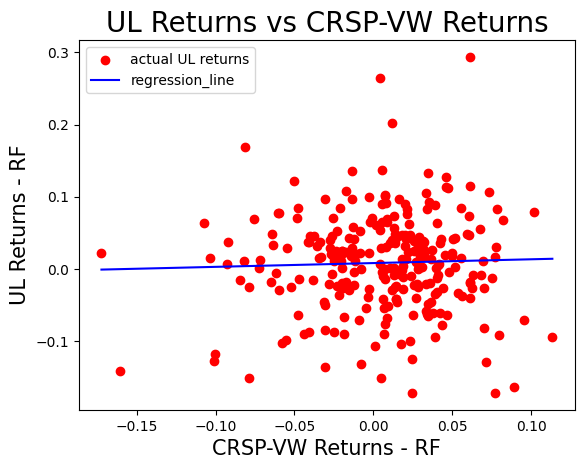


----Part c----
Under homoskedasticity assumption, covariance matrix = [[ 1.74836363e-05 -5.37728499e-05]
 [-5.37728499e-05  8.83167374e-03]]

----Part d----
H0: beta = 0; H1: beta != 0
Under homoskedasticity, p-values for regression coefficients = [0.05548097 0.57739093]

----Part e----
Plotting squared residuals to assess homoskedasticity...


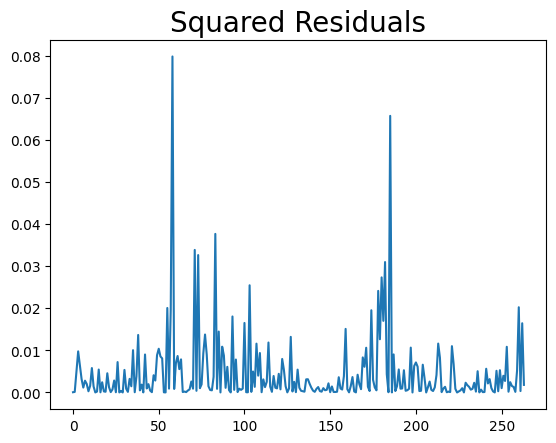


----Part f----
Under Homoskedasticity assumption,
For coeff 1, Standard Error = 0.0041813438402649086 90% CI = (0.0011413695252515225, 0.01494557682658608) 95% CI = (-0.00018984253558041592, 0.016276788887418018) 99% CI = (-0.002805960600145206, 0.018892906951982806)
For coeff 2, Standard Error = 0.0939769851876172 90% CI = (-0.10269739350034816, 0.2075563992138444) 95% CI = (-0.13261679283739353, 0.23747579855088974) 99% CI = (-0.1914148486765629, 0.2962738543900591)

----Part g----
Under heteroskedasticity assumption, covariance matrix = [[ 1.74836363e-05 -5.37728499e-05]
 [-5.37728499e-05  8.83167374e-03]]

----Part h----
Under Heteroskedasticity assumption,
For coeff 1, Standard Error = 0.004181343840264912 90% CI = (0.0011413695252515173, 0.014945576826586085) 95% CI = (-0.00018984253558042286, 0.016276788887418025) 99% CI = (-0.0028059606001452145, 0.018892906951982816)
For coeff 2, Standard Error = 0.0939769851876172 90% CI = (-0.10269739350034816, 0.2075563992138444) 95% CI = 

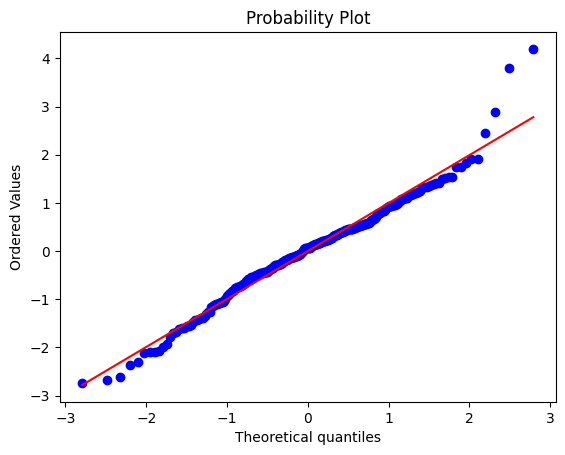

Jarque-Bera Test for Normality at 95% Significance:
JB-Statistic = 29.59168707978119; Lower Crit Value = 0.050635615968579795; Upper Crit Value = 7.377758908227871

----Part m----
Condition Number = 1.276332035063873e+16

----Part n----
With Ramsey RESET test, p-value = 0.03524902770777727

----Part o----
Running rolling regressions...


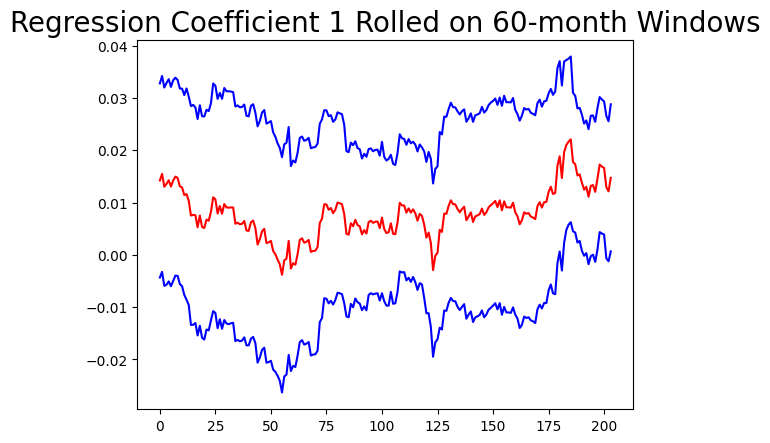

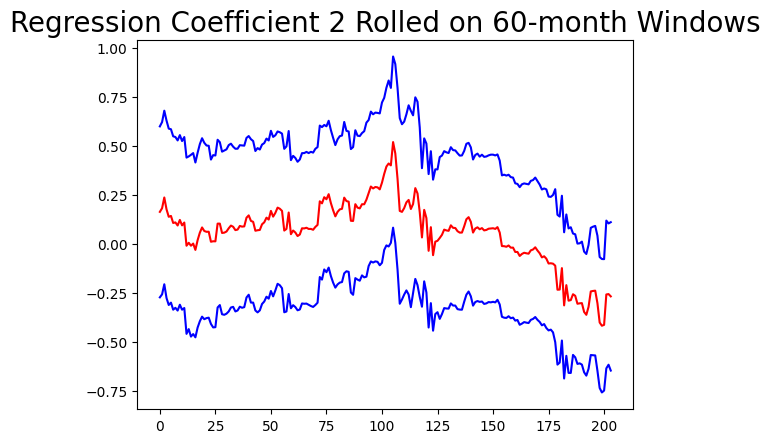

In [ ]:
get_regression_results(X1, y1)

(a) Both $R^2$ and adjusted-$R^2$ are very poor (close to 0 and negative respectively), indicating that the regression is not able to explain the variation in response variable well. Also, the regression coefficients are close to 1, indicating little linear dependence.

(b) There seems to be a very weak correlation - if we are being generous - between Unilever returns and the Market returns.

(c) Computed

(d) $\beta_1$ (the slope here) seems to be 0 due to the high p-value ($H_0$ not rejected). Even $\beta_0$ (the intercept) seems to be 0 due to a moderately high p-value.

(e) The squared residuals are certainly not uniform in magnitude, indicated by the pronounced peaks and troughs. This signals that the data is likely not homoskedastic.

(f) Computed

(g) Computed

(h) Computed

(i) Once again, the p-values indicate the coefficients are indeed 0.

(j) Computed

(k) The Durbin-Watson statistic (value = 2.3) indicates that there likely does not exist any significant autocorrelation between the residuals. The Breusch-Godfrey statistic corroborates (at 90% but not 95% significance level).

(l) As per the QQ-plot, the residuals are normally distributed (along the 45 degree) line except at the extreme ends. We can safely approximate them as normally distributed. The Jarque-Bera test rejects the notion of normality; however, as per the lecture, it usually does so (and hence is not very useful).

(m) Multicollinearity is not a problem for a single independent variable.

(n) The small p-value in the Ramsey RESET test indicates evidence against linear model specification at a 95% confidence level (with only a second order polynomial though).

(o) The plots of regression coefficients for the various time windows exhibit significant variance, indicating that a single regression model may not produce reliable results for the entire time period studied.

# Problem 2


----Part a----
Running the regression...
Regression Coefficients Beta = [ 0.00824356  0.09675669 -0.07486515]
R^2 = 0.002516759233544219
Adjusted R^2 = -0.00899266277529942

----Part b----
Plotting scatterplot with superimposed regression line...


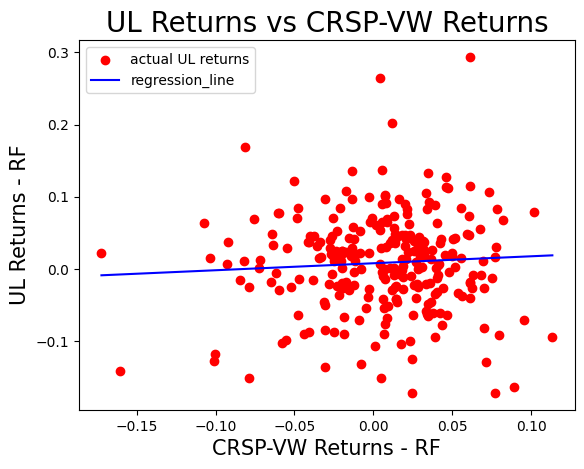


----Part c----
Under homoskedasticity assumption, covariance matrix = [[ 1.75731474e-05 -2.86771282e-05 -4.22629427e-05]
 [-2.86771282e-05  1.43636066e-02 -9.36299966e-03]
 [-4.22629427e-05 -9.36299966e-03  1.58133727e-02]]

----Part d----
H0: beta = 0; H1: beta != 0
Under homoskedasticity, p-values for regression coefficients = [0.05030254 0.42021345 0.55212987]

----Part e----
Plotting squared residuals to assess homoskedasticity...


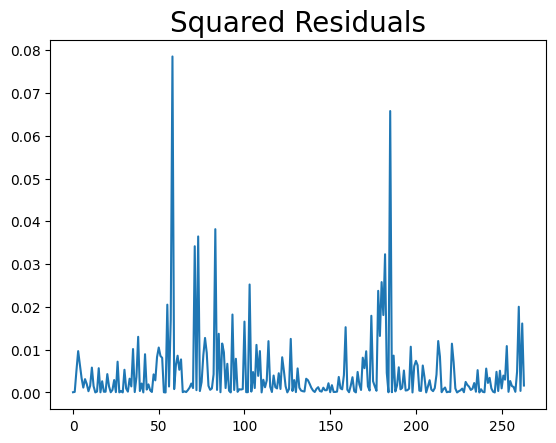


----Part f----
Under Homoskedasticity assumption,
For coeff 1, Standard Error = 0.004192033798311961 90% CI = (0.0013237148230640077, 0.015163401904993561) 95% CI = (-1.0953271231387354e-05, 0.016498069999288954) 99% CI = (-0.002633918479248737, 0.019121035207306306)
For coeff 2, Standard Error = 0.11984826476750418 90% CI = (-0.10107836162908906, 0.29459175018212935) 95% CI = (-0.13923589156271368, 0.332749280115754) 99% CI = (-0.2142252270143982, 0.4077386155674385)
For coeff 3, Standard Error = 0.12575123326850363 90% CI = (-0.2824443135808355, 0.13271400868832722) 95% CI = (-0.3224812424169898, 0.17275093752448145) 99% CI = (-0.40116407886295985, 0.2514337739704516)

----Part g----
Under heteroskedasticity assumption, covariance matrix = [[ 1.75731474e-05 -2.86771282e-05 -4.22629427e-05]
 [-2.86771282e-05  1.43636066e-02 -9.36299966e-03]
 [-4.22629427e-05 -9.36299966e-03  1.58133727e-02]]

----Part h----
Under Heteroskedasticity assumption,
For coeff 1, Standard Error = 0.00419203

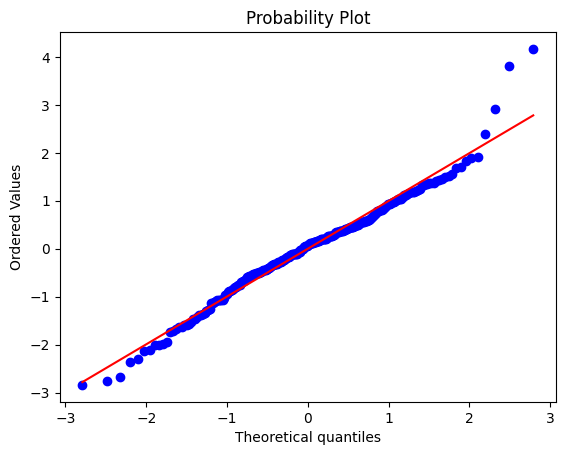

Jarque-Bera Test for Normality at 95% Significance:
JB-Statistic = 29.2676886984019; Lower Crit Value = 0.050635615968579795; Upper Crit Value = 7.377758908227871

----Part m----
Condition Number = 5.50136735557544e+47

----Part n----
With Ramsey RESET test, p-value = 0.06560325463214967

----Part o----
Running rolling regressions...


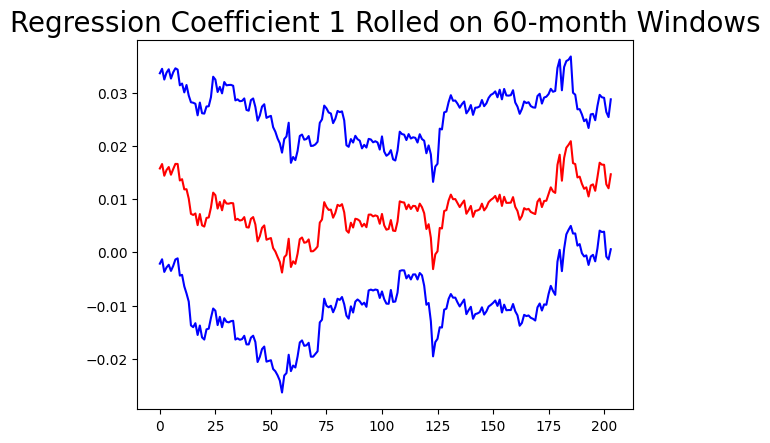

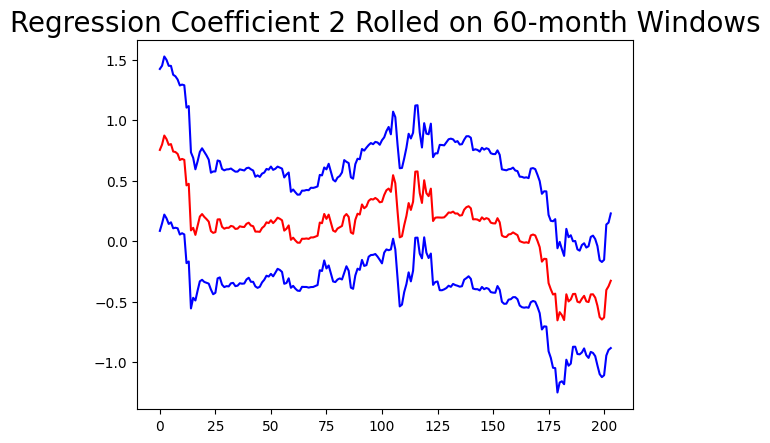

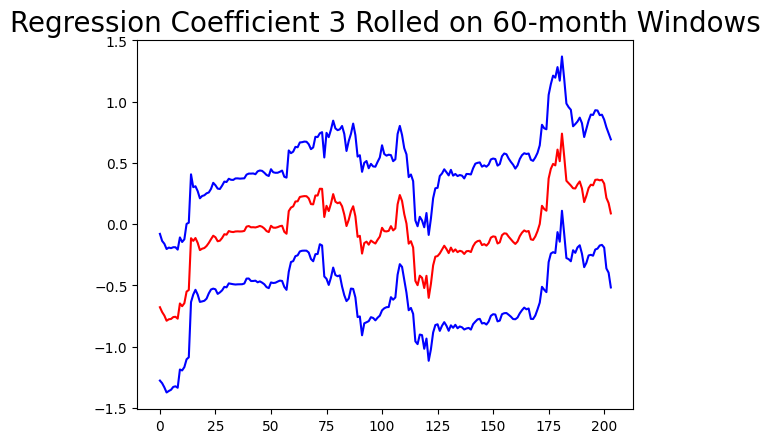

In [ ]:
get_regression_results(X2, y2)

(a) Both $R^2$ and adjusted-$R^2$ are very poor (close to 0 and negative respectively), indicating that the regression is not able to explain the variation in response variable well. Also, the regression coefficients are close to 1, indicating little linear dependence.

(b) There seems to be a very weak correlation - if we are being generous - between Unilever returns and the Market returns. Note that the plot is not linear because of the other independent variable ($R_{HH}$).

(c) Computed

(d) $\beta_1$ and $\beta_2$ (the partial slopes here) seems to be 0 due to the high p-value ($H_0$ not rejected). Even $\beta_0$ (the intercept) seems to be 0 due to a moderately high p-value.

(e) The squared residuals are certainly not uniform in magnitude, indicated by the pronounced peaks and troughs. This signals that the data is likely not homoskedastic.

(f) Computed

(g) Computed

(h) Computed

(i) Once again, the p-values indicate the coefficients are indeed 0.

(j) Computed

(k) The Durbin-Watson statistic (value = 2.28) indicates that there likely does not exist any significant autocorrelation between the residuals. The Breusch-Godfrey statistic corroborates (at 90% but not 95% significance level).

(l) As per the QQ-plot, the residuals are normally distributed (along the 45 degree) line except at the extreme ends. We can safely approximate them as normally distributed. The Jarque-Bera test rejects the notion of normality; however, as per the lecture, it usually does so (and hence is not very useful).

(m) Condition number is very high, indicating the problem of multicollinearity.

(n) The high p-value in the Ramsey RESET test indicates no significant evidence against linear model specification.

(o) The plots of regression coefficients for the various time windows exhibit significant variance, indicating that a single regression model may not produce reliable results for the entire time period studied.

# Problem 3

The adjusted-$R^2$ (lower value in 2) and BIC (higher value in 2) both indicate that model from 1. is better than that from 2. Furthermore, model in 2. clearly suffers from the problem of multicollinearty, as indicated by the high condition number.

We can run an alternative model using only Consumer Goods Index ($R_{HH}$) as the independent variable, as done below. The BIC still seems to indicate that model from 1. is slightly better.

(264, 2)

(264,)


----Part a----
Running the regression...
Regression Coefficients Beta = [ 0.00843673 -0.01179374]
R^2 = 5.412323238551536e-05
Adjusted R^2 = -0.007608297279243725

----Part b----
Plotting scatterplot with superimposed regression line...


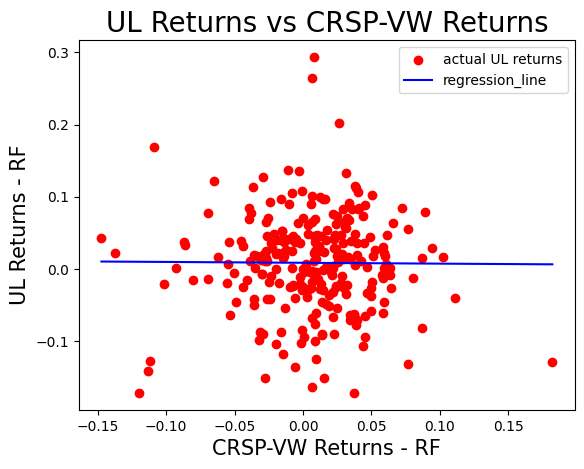


----Part c----
Under homoskedasticity assumption, covariance matrix = [[ 1.75591372e-05 -6.11067858e-05]
 [-6.11067858e-05  9.73402006e-03]]

----Part d----
H0: beta = 0; H1: beta != 0
Under homoskedasticity, p-values for regression coefficients = [0.04509869 0.90494083]

----Part e----
Plotting squared residuals to assess homoskedasticity...


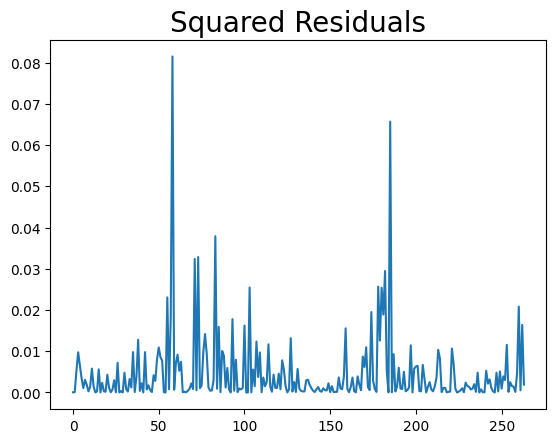


----Part f----
Under Homoskedasticity assumption,
For coeff 1, Standard Error = 0.004190362419750206 90% CI = (0.0015197438364532795, 0.015353724900849314) 95% CI = (0.00018566053559874486, 0.016687808201703846) 99% CI = (-0.0024361001332601478, 0.01930956887056274)
For coeff 2, Standard Error = 0.09866113752997897 90% CI = (-0.17465272515196723, 0.1510652370816823) 95% CI = (-0.20606341540675044, 0.1824759273364655) 99% CI = (-0.2677921786998301, 0.2442046906295451)

----Part g----
Under heteroskedasticity assumption, covariance matrix = [[ 1.75591372e-05 -6.11067858e-05]
 [-6.11067858e-05  9.73402006e-03]]

----Part h----
Under Heteroskedasticity assumption,
For coeff 1, Standard Error = 0.004190362419750207 90% CI = (0.0015197438364532778, 0.015353724900849314) 95% CI = (0.00018566053559874313, 0.01668780820170385) 99% CI = (-0.0024361001332601495, 0.019309568870562743)
For coeff 2, Standard Error = 0.09866113752997896 90% CI = (-0.1746527251519672, 0.15106523708168226) 95% CI = (-

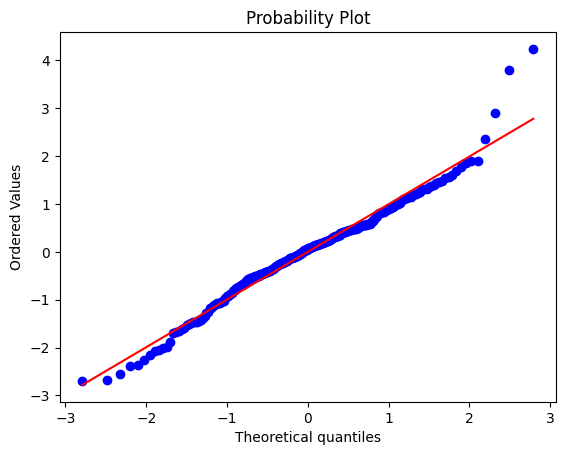

Jarque-Bera Test for Normality at 95% Significance:
JB-Statistic = 31.062221528174682; Lower Crit Value = 0.050635615968579795; Upper Crit Value = 7.377758908227871

----Part m----
Condition Number = 1.2761081529097534e+16

----Part n----
With Ramsey RESET test, p-value = 0.03178158419797161

----Part o----
Running rolling regressions...


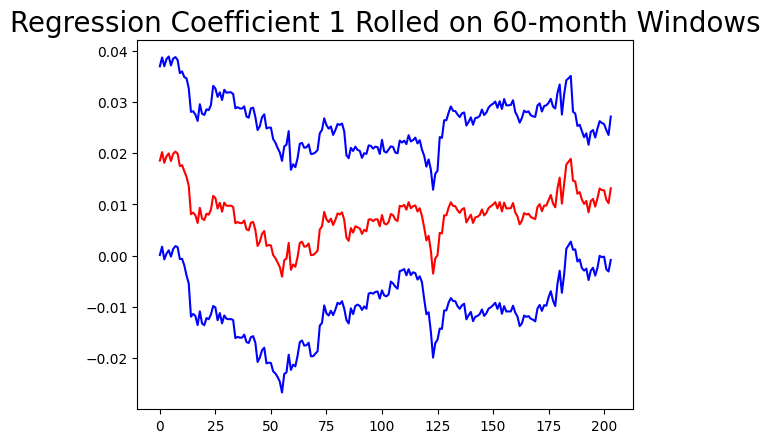

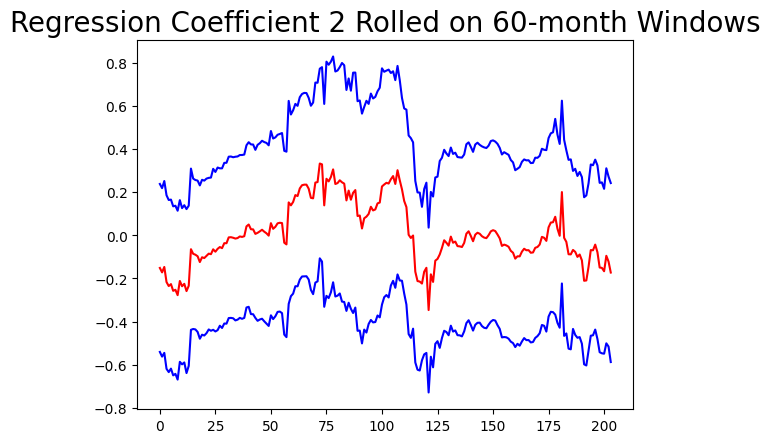

In [ ]:
# data for alternative model
X3 = df[["const", "hh_excess"]].to_numpy()
X3.shape
y3 = df["un_excess"].to_numpy()
y3.shape

get_regression_results(X3, y3)

# Problem 4

Since the models in both the lecture and the problem set showed instability in parameters across the time period studied, we can not use a single regression model for the entire time period. Instead, we report the regression coefficients from the last 60-day rolling window.

Also, for the problem set, I am going with model specification from 1. Similarly, we choose the best model specification from the lecture. Next, we report the last beta values from our 60-day rolling regression plots.